# Daisyworld: A simple climate/biosphere feedback model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Matsuno scheme

[ 35.   35.   35.   35.   35.   35.   35.   35.   35.   35.   35.   35.
  35.   35.   35.   35.   35.   35.   35.   35.   35.   35.   35.   35.
  34.9  31.   32.8  96.5  61.   47.8  39.5  33.7  28.4  21.7  17.8  15.8
  14.8  14.6   9.1  13.   21.3  23.6  25.4  27.   28.8  30.7  32.7  35.1
  37.8  41.   44.7  49.3  55.   62.4  72.4  86.8 109.7 152.6 160.9  24.3
  25.2  26.   26.7  27.4  27.9  28.4  28.9  29.4  29.9  30.3  30.8  31.2
  31.7  32.2  32.7  33.3  34.   34.9  35.   35.   35.   35.   35.   35.
  35.   35.   35.   35.   35.   35.   35.   35.   35.   35.   35.   35.
  35.   35.   35.   35. ]


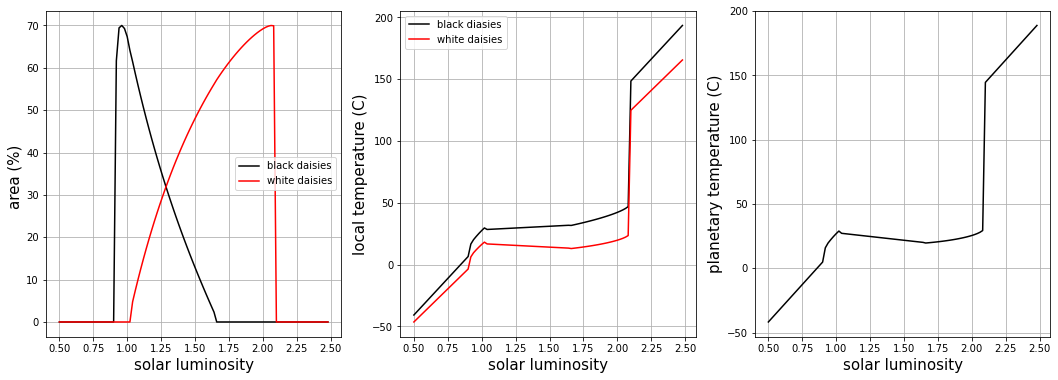

In [19]:
#Matsuno use aa=0, bb=1. 

# Functions
def fw(area_white, area_black, S, L): 
    
    area_ground = 1 - (area_black + area_white)

    # Planetary albedo
    alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black
   
    # Planetary temperature
    Tp = (0.25*S*L*(1-alb_planetary)-Ι0)/(b) + Kelvin_offset# Kelvin or Celsius? 

    # Local temperatures
    Tw = S*L*(alb_planetary-alb_white)/(4*(b + beta_coef)) + Tp # Kelvin or Celsius?

    # Determine birth rates
    if (Tw >= T_min and Tw <= T_max and (area_white) >= 0.01): 
        beta_white = 1 - 4*np.power(T_ideal - Tw, 2)/(np.power(T_max - T_min, 2))
    else:
        beta_white = 0
        
    return area_white*(area_ground*beta_white - gamma)


def fb(area_white, area_black, S, L):
    
    area_ground = 1 - (area_black + area_white)

    # Planetary albedo
    alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black  

    # Planetary temperature
    Tp = (0.25*S*L*(1-alb_planetary)-Ι0)/(b) + Kelvin_offset# Kelvin or Celsius? 

    # Local temperatures
    Tb = S*L*(alb_planetary-alb_black)/(4*(b + beta_coef)) + Tp # Kelvin or Celsius?

    # Determine birth rates
    if (Tb >= T_min and Tb <= T_max and (area_black) >= 0.01): 
        beta_black = 1 - 4*np.power(T_ideal - Tb, 2)/(np.power(T_max - T_min, 2))
    else:
        beta_black = 0
        
    return area_black*(area_ground*beta_black - gamma)


def Matsuno(area_white,area_black,S,L,dt):
    
    area_white_pred = area_white+fw(area_white, area_black,S,L)*dt # prediction step 1
    area_black_pred = area_black+fb(area_white, area_black,S,L)*dt 
    #area_ground_pred = 1 - area_white_pred - area_black_pred
        
    area_white_cor = area_white + dt*(aa*fw(area_white, area_black,S,L)+bb*fw(area_white_pred, area_black_pred, S ,L))
    area_black_cor = area_black + dt*(aa*fb(area_white, area_black,S,L)+bb*fb(area_white_pred, area_black_pred, S ,L))
        
    return area_white_cor, area_black_cor


# matsuno
aa=0
bb=1

# Constants 
b = 2.2         # W m-2 K-1
beta_coef=16    # W m-2 K-1
Ι0 = 220

# Temperatures
#Kelvin_offset = 273.15
Kelvin_offset = 0                # ??????????????
T_min = 5 + Kelvin_offset
T_max = 40 + Kelvin_offset
T_ideal = 22.5 + Kelvin_offset

# Albedo
alb_white = 0.75
alb_black = 0.15
alb_ground = 0.25

#Area (%)
area_black = 0.01
area_white = 0.01

#Rates
#gamma = 0.3 # death rate s-1

# Flux terms
S = 1366  #Solar flux constant  W m-2
sigma = 5.67032e-8 # Stefab-boltzman constant W m-2 K-4
gamma=0.3

# Flux limits and step
L_min = 0.5
L_max = 2.5
L_step = 0.02

# Arrays
L = np.arange(L_min, L_max, L_step)
area_black_vec = np.zeros(len(L))
area_white_vec = np.zeros(len(L))
area_ground_vec = np.zeros(len(L))
Tp_vec = np.zeros(len(L)) # planetary temperature 
Tw_vec = np.zeros(len(L)) # local temperature - white
Tb_vec = np.zeros(len(L)) # local temperature - black
Tp_vec_pred = np.zeros(len(L)) # planetary temperature 
Tw_vec_pred = np.zeros(len(L)) # local temperature - white
Tb_vec_pred = np.zeros(len(L)) # local temperature - black
total_time = np.zeros(len(L)) # time that daisies need to reach the steady state

dt=0.1 # time-step 
tol=1e-8  # tolerance

area_b_old=0.01
area_w_old=0.01

for i in range(len(L)):
    
    # Initial Area (%)
    area_black = max(area_b_old,0.01)
    area_white = max(area_w_old,0.01)
    area_ground = 1 - (area_black + area_white)
    
    # Initial time
    t=0
    
    # Choose an initial tolerance randomly
    darea_b_tol = 1
    darea_w_tol = 1
    
    ###
    #area_b_old = 0
    #area_w_old = 0
    
    while darea_w_tol > tol and darea_b_tol > tol: 
      
        # Planetary albedo
        alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black  
        
        # Planetary temperature
        Tp_vec[i] = (0.25*S*L[i]*(1-alb_planetary)-Ι0)/(b) # Kelvin or Celsius? 
        
        # Local temperatures
        Tw_vec[i] = S*L[i]*(alb_planetary-alb_white)/(4*(b + beta_coef)) + Tp_vec[i] # Kelvin or Celsius?
        Tb_vec[i] = S*L[i]*(alb_planetary-alb_black)/(4*(b + beta_coef)) + Tp_vec[i] # Kelvin or Celsius?

        # Determine birth rates
        if (Tw_vec[i] >= T_min and Tw_vec[i] <= T_max and (area_white) >= 0.01):
            beta_white = 1 - (4*np.power(T_ideal - Tw_vec[i], 2)/(np.power(T_max - T_min, 2)))
        else:
            beta_white = 0

        if (Tb_vec[i] >= T_min and Tb_vec[i] <= T_max and area_black >= 0.01):
            beta_black = 1 - (4*np.power(T_ideal - Tb_vec[i], 2)/(np.power(T_max - T_min, 2)))
        else:
            beta_black = 0
        
        
        area_white, area_black = Matsuno(area_white,area_black,S,L[i],dt)
        area_ground = 1 - area_white - area_black
        
        # New tolerance
        darea_b_tol = abs(area_black - area_b_old)
        darea_w_tol = abs(area_white - area_w_old)
        
        # for the next iteration 
        area_b_old = area_black
        area_w_old = area_white                                          
        # Time
        t=t+dt        
                                         
        # end of while loop
        
    # Fill the arrays  
    area_white_vec[i] = area_white
    area_black_vec[i] = area_black
    area_ground_vec[i] = area_ground
    total_time[i] = t
    
print(total_time) #Matsuno takes more time

fig, axs = plt.subplots(1, 3,figsize=(18,6))
axs[0].set_xlabel('solar luminosity',fontsize=15)
axs[0].set_ylabel('area (%) ',fontsize=15)
axs[0].plot(L, 100*area_black_vec, color='black', label='black daisies')
axs[0].plot(L, 100*area_white_vec, color='red', label='white daisies')
axs[0].grid()
axs[0].legend()

axs[1].set_xlabel('solar luminosity',fontsize=15)
axs[1].set_ylabel('local temperature (C)' ,fontsize=15)
axs[1].plot(L, Tb_vec, color='black', label='black diasies')
axs[1].plot(L, Tw_vec, color='red', label='white daisies')
axs[1].grid()
axs[1].legend()

axs[2].set_xlabel('solar luminosity',fontsize=15)
axs[2].set_ylabel('planetary temperature (C)' ,fontsize=15)
axs[2].plot(L, Tp_vec, color='black')
axs[2].grid()

### Heun scheme 

[ 34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5
  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5
  34.5  30.6  32.4  96.3  60.7  47.4  39.   33.2  27.7  20.7  16.9  15.
  14.   13.8  14.4  12.   20.6  23.   24.9  26.6  28.3  30.2  32.3  34.7
  37.4  40.6  44.3  48.9  54.7  62.1  72.1  86.5 109.4 152.3 160.5  24.
  24.9  25.7  26.4  27.   27.6  28.1  28.6  29.   29.5  29.9  30.4  30.8
  31.3  31.8  32.3  32.9  33.6  34.4  34.5  34.5  34.5  34.5  34.5  34.5
  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5  34.5
  34.5  34.5  34.5  34.5]


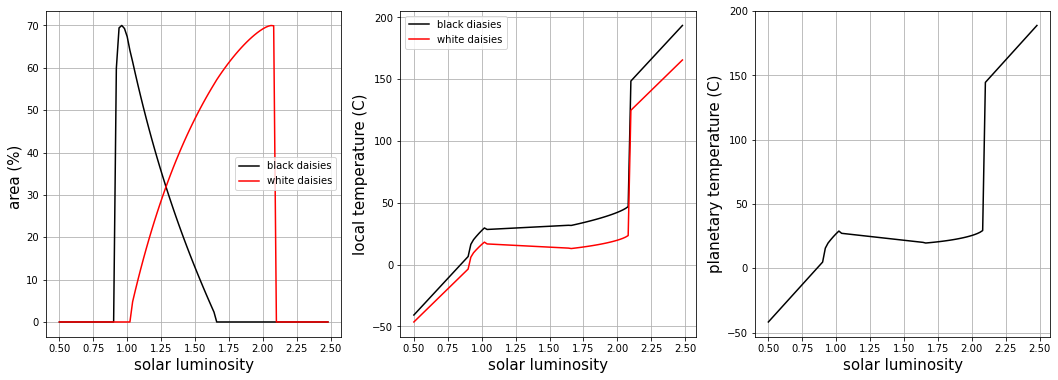

In [20]:
#Heun use aa=0.5, bb=0.5. 

# Functions
def fw(area_white, area_black, S, L): 
    
    area_ground = 1 - (area_black + area_white)

    # Planetary albedo
    alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black
   
    # Planetary temperature
    Tp = (0.25*S*L*(1-alb_planetary)-Ι0)/(b) + Kelvin_offset# Kelvin or Celsius? 

    # Local temperatures
    Tw = S*L*(alb_planetary-alb_white)/(4*(b + beta_coef)) + Tp # Kelvin or Celsius?

    # Determine birth rates
    if (Tw >= T_min and Tw <= T_max and (area_white) >= 0.01): 
        beta_white = 1 - 4*np.power(T_ideal - Tw, 2)/(np.power(T_max - T_min, 2))
    else:
        beta_white = 0
        
    return area_white*(area_ground*beta_white - gamma)


def fb(area_white, area_black, S, L):
    
    area_ground = 1 - (area_black + area_white)

    # Planetary albedo
    alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black  

    # Planetary temperature
    Tp = (0.25*S*L*(1-alb_planetary)-Ι0)/(b) + Kelvin_offset# Kelvin or Celsius? 

    # Local temperatures
    Tb = S*L*(alb_planetary-alb_black)/(4*(b + beta_coef)) + Tp # Kelvin or Celsius?

    # Determine birth rates
    if (Tb >= T_min and Tb <= T_max and (area_black) >= 0.01): 
        beta_black = 1 - 4*np.power(T_ideal - Tb, 2)/(np.power(T_max - T_min, 2))
    else:
        beta_black = 0
        
    return area_black*(area_ground*beta_black - gamma)


def Matsuno(area_white,area_black,S,L,dt):
    
    area_white_pred = area_white+fw(area_white, area_black,S,L)*dt # prediction step 1
    area_black_pred = area_black+fb(area_white, area_black,S,L)*dt 
    #area_ground_pred = 1 - area_white_pred - area_black_pred
        
    area_white_cor = area_white + dt*(aa*fw(area_white, area_black,S,L)+bb*fw(area_white_pred, area_black_pred, S ,L))
    area_black_cor = area_black + dt*(aa*fb(area_white, area_black,S,L)+bb*fb(area_white_pred, area_black_pred, S ,L))
        
    return area_white_cor, area_black_cor


# matsuno
aa=0.5
bb=0.5

# Constants 
b = 2.2         # W m-2 K-1
beta_coef=16    # W m-2 K-1
Ι0 = 220

# Temperatures
#Kelvin_offset = 273.15
Kelvin_offset = 0                # ??????????????
T_min = 5 + Kelvin_offset
T_max = 40 + Kelvin_offset
T_ideal = 22.5 + Kelvin_offset

# Albedo
alb_white = 0.75
alb_black = 0.15
alb_ground = 0.25

#Area (%)
area_black = 0.01
area_white = 0.01

#Rates
#gamma = 0.3 # death rate s-1

# Flux terms
S = 1366  #Solar flux constant  W m-2
sigma = 5.67032e-8 # Stefab-boltzman constant W m-2 K-4
gamma=0.3

# Flux limits and step
L_min = 0.5
L_max = 2.5
L_step = 0.02

# Arrays
L = np.arange(L_min, L_max, L_step)
area_black_vec = np.zeros(len(L))
area_white_vec = np.zeros(len(L))
area_ground_vec = np.zeros(len(L))
Tp_vec = np.zeros(len(L)) # planetary temperature 
Tw_vec = np.zeros(len(L)) # local temperature - white
Tb_vec = np.zeros(len(L)) # local temperature - black
Tp_vec_pred = np.zeros(len(L)) # planetary temperature 
Tw_vec_pred = np.zeros(len(L)) # local temperature - white
Tb_vec_pred = np.zeros(len(L)) # local temperature - black
total_time = np.zeros(len(L)) # time that daisies need to reach the steady state

dt=0.1 # time-step 
tol=1e-8  # tolerance

area_b_old=0.01
area_w_old=0.01

for i in range(len(L)):
    
    # Initial Area (%)
    area_black = max(area_b_old,0.01)
    area_white = max(area_w_old,0.01)
    area_ground = 1 - (area_black + area_white)
    
    # Initial time
    t=0
    
    # Choose an initial tolerance randomly
    darea_b_tol = 1
    darea_w_tol = 1
    
    ###
    #area_b_old = 0
    #area_w_old = 0
    
    while darea_w_tol > tol and darea_b_tol > tol: 
      
        # Planetary albedo
        alb_planetary = area_ground*alb_ground + area_white*alb_white + area_black*alb_black  
        
        # Planetary temperature
        Tp_vec[i] = (0.25*S*L[i]*(1-alb_planetary)-Ι0)/(b) # Kelvin or Celsius? 
        
        # Local temperatures
        Tw_vec[i] = S*L[i]*(alb_planetary-alb_white)/(4*(b + beta_coef)) + Tp_vec[i] # Kelvin or Celsius?
        Tb_vec[i] = S*L[i]*(alb_planetary-alb_black)/(4*(b + beta_coef)) + Tp_vec[i] # Kelvin or Celsius?

        # Determine birth rates
        if (Tw_vec[i] >= T_min and Tw_vec[i] <= T_max and (area_white) >= 0.01):
            beta_white = 1 - (4*np.power(T_ideal - Tw_vec[i], 2)/(np.power(T_max - T_min, 2)))
        else:
            beta_white = 0

        if (Tb_vec[i] >= T_min and Tb_vec[i] <= T_max and area_black >= 0.01):
            beta_black = 1 - (4*np.power(T_ideal - Tb_vec[i], 2)/(np.power(T_max - T_min, 2)))
        else:
            beta_black = 0
        
        
        area_white, area_black = Matsuno(area_white,area_black,S,L[i],dt)
        area_ground = 1 - area_white - area_black
        
        # New tolerance
        darea_b_tol = abs(area_black - area_b_old)
        darea_w_tol = abs(area_white - area_w_old)
        
        # for the next iteration 
        area_b_old = area_black
        area_w_old = area_white                                          
        # Time
        t=t+dt        
                                         
        # end of while loop
        
    # Fill the arrays  
    area_white_vec[i] = area_white
    area_black_vec[i] = area_black
    area_ground_vec[i] = area_ground
    total_time[i] = t
    
print(total_time) #Matsuno takes more time

fig, axs = plt.subplots(1, 3,figsize=(18,6))
axs[0].set_xlabel('solar luminosity',fontsize=15)
axs[0].set_ylabel('area (%) ',fontsize=15)
axs[0].plot(L, 100*area_black_vec, color='black', label='black daisies')
axs[0].plot(L, 100*area_white_vec, color='red', label='white daisies')
axs[0].grid()
axs[0].legend()

axs[1].set_xlabel('solar luminosity',fontsize=15)
axs[1].set_ylabel('local temperature (C)' ,fontsize=15)
axs[1].plot(L, Tb_vec, color='black', label='black diasies')
axs[1].plot(L, Tw_vec, color='red', label='white daisies')
axs[1].grid()
axs[1].legend()

axs[2].set_xlabel('solar luminosity',fontsize=15)
axs[2].set_ylabel('planetary temperature (C)' ,fontsize=15)
axs[2].plot(L, Tp_vec, color='black')
axs[2].grid()